## Bottom Pressure Torque calculation


\begin{equation}
\beta \overline{\int_{-H}^{\eta}vdz} = \dfrac{1}{\rho_o}\overline{J(p_b, H)} - \overline{\dfrac{fQ_m}{\rho_o}} + \dfrac{1}{\rho_o}\nabla \wedge\overline{\left(\boldsymbol{\tau_s - \tau_b}\right)} + \overline{\nabla \wedge \int_{-H}^{\eta}\mathbf{a}dz} + \overline{\nabla \wedge \int_{-H}^{\eta}\mathbf{b}dz} \tag{1}
\end{equation}

The equation above is expected to the main balance in a steady state. We would like to compute individual term and compare their magnitudes in different regions.


The calculation of bottom pressure torque (BPT) is tricky because spatial gradients are large and slight differences in numbers can lead to large errors. Here, we compute the bottom pressure torque using three different methods and compare the results. In direction computation, BPT can be computed as 

#### Method 1
$$BPT = J(p_b,H) = \nabla \wedge \left(p_b \nabla H\right) = - \nabla \wedge \left(H \nabla p_b\right) \tag{2}$$ 


#### Method 2

In the second method for bottom pressure torque ($BPT = \dfrac{1}{\rho_o}\overline{J(p_b, H)}$), we do not compute Jabobian directly because it tends to very noisy. Instead, we take curl of the H x depth-avg pressure gradient acceleration diagnostics to compute BPT. 

$$ BPT = \nabla \wedge \int_{-H}^{\eta}\dfrac{-\nabla p}{\rho_o} = \nabla \wedge \left[H \times \left(- \Sigma_k(h_k/\mathcal{D})\left(\dfrac{\nabla_s p_k + \nabla_s \Phi_k}{\rho_o}\right)\right)\right] \tag{3}$$

Later, we also compare this calculation against equation 5.


#### Method 3
$$BPT = H(JEBAR) + f \langle\mathbf{u}_g\rangle\cdot \nabla H \tag{4} $$ 

Depth-averaged pressure gradiet dignostics are available, so we can compute depth-averaged geostrophic velocity $\langle\mathbf{u}_g\rangle$ as the following

$$ f \mathbf{\hat{z}} \wedge\langle \mathbf{u}_g \rangle = - \Sigma_k (h_k/\mathcal{D})\left(\dfrac{\nabla_s p_k + \nabla_s \Phi_k}{\rho_o} \right) \tag{5}$$


We can then compute $f \langle\mathbf{u}_g\rangle\cdot \nabla H$ to get BPT. However, large gradients in H can lead to large errors. There is an alternative method. We know that 

\begin{equation}
- \nabla \wedge \left[f \mathbf{\hat{z}} \wedge \left(\dfrac{1}{\mathcal{D}}\int_{-H}^{\eta}\mathbf{u}dz\right)\right]  = - \beta \langle v\rangle  + f\dfrac{\langle\mathbf{u}\rangle\cdot \nabla \mathcal{D}}{\mathcal{D}}   - \dfrac{f}{\mathcal{D}}\dfrac{Q_m}{\rho_o} \tag{6}
\end{equation}

Here, $\mathcal{D} = H +\eta$. From equation 3, we can write (assuming long time-mean of depth-avg velocity is close to depth-averaged geostrophic velocity)

$$f \langle\mathbf{u}_g\rangle\cdot \nabla H \approx - H \nabla \wedge \left[f \mathbf{\hat{z}} \wedge \left(\dfrac{1}{\mathcal{D}}\int_{-H}^{\eta}\mathbf{u}dz\right)\right]  + H \beta \langle v\rangle + f\dfrac{Q_m}{\rho_o} \tag{7}$$

Or one use a more general form of the above equation

$$f \langle\mathbf{u}_g\rangle\cdot \nabla H \approx - H \nabla \wedge \left[f \mathbf{\hat{z}} \wedge \left(\dfrac{1}{\mathcal{D}}\int_{-H}^{\eta}\mathbf{u}dz\right)\right]  + H \beta \langle v\rangle + \dfrac{f}{H}\nabla\cdot\left(\int_{-H}^{\eta}\mathbf{u}dz\right) \tag{7}$$

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
from xgcm import Grid
import filter
from dask.diagnostics import ProgressBar
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import glob, os

#from dask.distributed import Client
#from dask.distributed import LocalCluster
#cluster = LocalCluster()
#client = Client(cluster)

#client

In [2]:
# Functions for plotting

def plot_map(ax, da, vmin=-999, vmax=999, vstep=1,
             lon='geolon', lat='geolat', cmap='RdBu_r', title='what is it?'):
    
    contours = np.arange(vmin, vmax+vstep, vstep)
    
    p = da.plot(ax=ax, x=lon, y=lat, vmin=vmin, vmax=vmax, cmap=cmap, 
                transform=ccrs.PlateCarree(), add_labels=False, add_colorbar=False)
    
    # add separate colorbar
    cb = plt.colorbar(p, ax=ax, format='%.1e', extend='both', shrink=0.6)
    cb.ax.tick_params(labelsize=12)

    p.axes.gridlines(color='black', alpha=0.5, linestyle='--')
    
    _ = plt.title(title, fontsize=14)
    return fig

def plot_sec(ax, da, vmin=-999, vmax=999, vstep=1, lat_lon_ext = [-180, 180, -85., 85.],
             lon='geolon', lat='geolat', cmap='RdBu_r', title='what is it?'):
    
    contours = np.arange(vmin, vmax+vstep, vstep)
    
    p = da.plot(ax=ax, x=lon, y=lat, vmin=vmin, vmax=vmax, cmap=cmap, 
                transform=ccrs.PlateCarree(), add_labels=False, add_colorbar=False)
    
    # add separate colorbar
    cb = plt.colorbar(p, ax=ax, format='%.1e', extend='both', shrink=0.6)
    cb.ax.tick_params(labelsize=12)
    
    ax.set_extent(lat_lon_ext, crs=ccrs.PlateCarree())
    
    # parallels/meridiens
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=2, color='gray', alpha=0.5, linestyle='--')
    gl.xlabels_top = False
    gl.ylabels_right = False
    #gl.ylocator = mticker.FixedLocator([-80, -70, -60, -50, -40, -30])
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 12, 'color': 'black'}
    gl.ylabel_style = {'size': 12, 'color': 'black'}
    
    #ax.set_adjustable('datalim')
    
    ax.set_aspect(2.0)

    #p.axes.gridlines(color='black', alpha=0.5, linestyle='--')
    
    _ = plt.title(title, fontsize=14)
    return fig

In [3]:
def apply_gaussian_filter(field,wetMask,NL_g,sL_g,NB_g,sB_g):
    np = _get_array_module(field)

    fieldBar = field.copy()
    fieldBar = np.nan_to_num(fieldBar) 
    fieldBar = fieldBar * wetMask # Initalize the filtering process
    for i in range(NL_g):
        tempL = simple_Laplacian(fieldBar,wetMask) # Compute Laplacian
        fieldBar = fieldBar + (1/sL_g[i])*tempL # Update filtered field
    for i in range(NB_g): 
        tempL = simple_Laplacian(fieldBar,wetMask) # Compute Laplacian
        tempB = simple_Laplacian(tempL,wetMask) # Compute Biharmonic
        fieldBar = fieldBar + (2*np.real(sB_g[i])/np.abs(sB_g[i])**2)*tempL + (1/np.abs(sB_g[i])**2)*tempB
        
    return fieldBar

def apply_taper_filter(field,wetMask,NL_t,sL_t,NB_t,sB_t):
    np = _get_array_module(field)

    fieldBar = field.copy()
    fieldBar = np.nan_to_num(fieldBar) 
    fieldBar = fieldBar * wetMask # Initalize the filtering process
    for i in range(NL_t):
        tempL = simple_Laplacian(fieldBar,wetMask) # Compute Laplacian
        fieldBar = fieldBar + (1/sL_t[i])*tempL # Update filtered field
    for i in range(NB_t): 
        tempL = simple_Laplacian(fieldBar,wetMask) # Compute Laplacian
        tempB = simple_Laplacian(tempL,wetMask) # Compute Biharmonic
        fieldBar = fieldBar + (2*np.real(sB_t[i])/np.abs(sB_t[i])**2)*tempL + (1/np.abs(sB_t[i])**2)*tempB
        
    return fieldBar

def simple_Laplacian(phi,wetMask):
    np = _get_array_module(phi)

    out = phi.copy()
    out = np.nan_to_num(out) 
    out = wetMask * out 
    
    fac = (np.roll(wetMask, -1, axis=-1) 
            + np.roll(wetMask, 1, axis=-1) 
            + np.roll(wetMask, -1, axis=-2) 
            + np.roll(wetMask, 1, axis=-2)  
    )
        
    out = (- fac * out
            + np.roll(out, -1, axis=-1) 
            + np.roll(out, 1, axis=-1) 
            + np.roll(out, -1, axis=-2) 
            + np.roll(out, 1, axis=-2)
    )
        
    out = wetMask * out
    return out

try:
    from cupy import get_array_module as _get_array_module
except ImportError:
    import numpy as np

    def _get_array_module(*args):
        return np

In [4]:
ds = xr.open_dataset("/work/Hemant.Khatri/MOM6_idealised/MOM_budget/Global_125/Mom_Budget_OM125_0001-0005.nc")

ds = ds.sel(yh = slice(0,80.), yq = slice(0,80.), xh = slice(-100, 10.), xq = slice(-100, 10.))

print(ds)

<xarray.Dataset>
Dimensions:           (nv: 2, xh: 835, xq: 835, yh: 964, yq: 964, zi: 76)
Coordinates:
  * nv                (nv) float64 1.0 2.0
  * xh                (xh) float64 -99.93 -99.78 -99.63 ... 9.657 9.773 9.888
  * yh                (yh) float64 0.0 0.125 0.25 0.375 ... 79.84 79.89 79.95
  * xq                (xq) float64 -100.0 -99.85 -99.7 ... 9.657 9.773 9.888
  * yq                (yq) float64 0.0625 0.1875 0.3125 ... 79.86 79.92 79.97
  * zi                (zi) float64 0.0 2.0 4.0 ... 3.461e+03 3.722e+03 6.5e+03
Data variables:
    average_DT        timedelta64[ns] ...
    col_height        (yh, xh) float32 ...
    hf_CAu_2d         (yh, xq) float32 ...
    hf_CAv_2d         (yq, xh) float32 ...
    hf_PFu_2d         (yh, xq) float32 ...
    hf_PFv_2d         (yq, xh) float32 ...
    hf_diffu_2d       (yh, xq) float32 ...
    hf_diffv_2d       (yq, xh) float32 ...
    hf_du_dt_visc_2d  (yh, xq) float32 ...
    hf_dudt_2d        (yh, xq) float32 ...
    hf_dv_dt_visc_

### Filter Testing 

# Laplacian steps: 16; # Biharmonic steps: 2


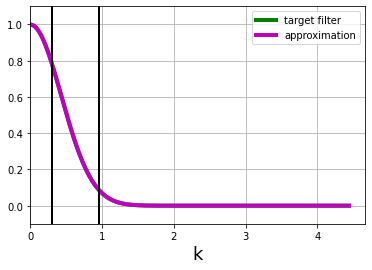

In [5]:
# Set Filter

# Guassian Filter set 

filter_fac = 8 # 1/8 --> 1 Deg

Lf_g = filter_fac/np.sqrt(6) 
N_g = 20
NL_g, sL_g, NB_g, sB_g = filter.filterSpec(N_g, 1, Lf_g, 'Gaussian')
print('# Laplacian steps: ' + str(NL_g) + '; # Biharmonic steps: ' + str(NB_g))

# Laplacian steps: 56; # Biharmonic steps: 2


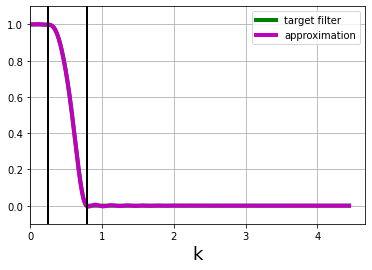

In [6]:
# Guassian Filter set 
Lf_t = filter_fac/2
N_t = 60
NL_t, sL_t, NB_t, sB_t = filter.filterSpec(N_t, 1, Lf_t, 'Taper')
print('# Laplacian steps: ' + str(NL_t) + '; # Biharmonic steps: ' + str(NB_t))

In [7]:
# Test filtering on ocean_depth

dims = ['yh', 'xh']

dataBar = ds['deptho'].copy() # Initialize the filtering process
dataBar = dataBar * ds['areacello']

dataBar = xr.apply_ufunc(apply_gaussian_filter, dataBar, ds['wet'], NL_g, sL_g, NB_g, sB_g, 
                         input_core_dims=[dims,dims, [], [], [], []],output_core_dims=[dims], 
                         output_dtypes=[dataBar.dtype], dask='parallelized')

#dataBar.data = dataBar.data.map_blocks(cp.asnumpy) # send back to host
dataBar = xr.where(ds['wet'],dataBar,np.nan) # mask by nan's if on land
dataBar = dataBar/ds['areacello'] # divide by cell area    
            
depth_g = dataBar.copy()

dataBar = ds['deptho'].copy() # Initialize the filtering process
dataBar = dataBar * ds['areacello']

dataBar = xr.apply_ufunc(apply_taper_filter, dataBar, ds['wet'], NL_t, sL_t, NB_t, sB_t, 
                         input_core_dims=[dims,dims, [], [], [], []],output_core_dims=[dims], 
                         output_dtypes=[dataBar.dtype], dask='parallelized')

#dataBar.data = dataBar.data.map_blocks(cp.asnumpy) # send back to host
dataBar = xr.where(ds['wet'],dataBar,np.nan) # mask by nan's if on land
dataBar = dataBar/ds['areacello'] # divide by cell area    
            
depth_t = dataBar.copy()

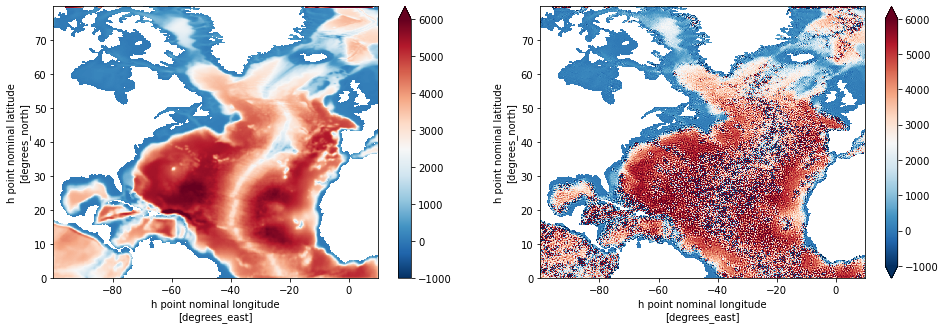

In [8]:
fig = plt.figure(figsize=[16,5])

plt.subplot(1,2,1)
(depth_g - 0*ds['deptho']).plot(vmin=-1000., vmax=6000., cmap='RdBu_r')

plt.subplot(1,2,2)
(depth_t - 0*ds['deptho']).plot(vmin=-1000., vmax=6000., cmap='RdBu_r')

# Better to stick with guassian filter

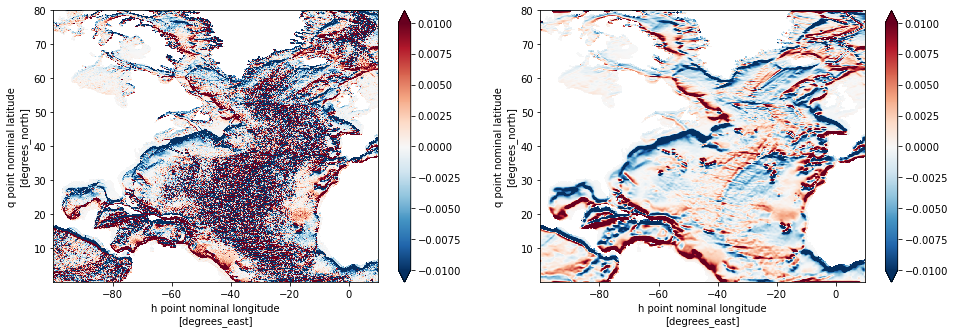

In [9]:
grid = Grid(ds, coords={'X': {'center': 'xh', 'right': 'xq'},
                        'Y': {'center': 'yh', 'right': 'yq'} }, periodic=[ ])

fig = plt.figure(figsize=[16,5])

plt.subplot(1,2,1)
(grid.diff(ds.deptho, 'Y',  boundary='fill') / ds['dyCv']).plot(vmin=-1.e-2, vmax=1.e-2, cmap='RdBu_r')

plt.subplot(1,2,2)
(grid.diff(depth_g, 'Y',  boundary='fill') / ds['dyCv']).plot(vmin=-1.e-2, vmax=1.e-2, cmap='RdBu_r')

### Compute vorticity budget terms

In [10]:
# Create grid and interpolate depth, beta

grid = Grid(ds, coords={'X': {'center': 'xh', 'right': 'xq'},
                        'Y': {'center': 'yh', 'right': 'yq'} }, periodic=[ ])

depth_u = grid.interp(ds['deptho'], 'X',  boundary='fill') 
depth_v = grid.interp(ds['deptho'], 'Y',  boundary='fill')

depthg_u = grid.interp(depth_g, 'X',  boundary='fill') 
depthg_v = grid.interp(depth_g, 'Y',  boundary='fill')

depth_q = grid.interp(depth_v, 'X',  boundary='fill')
depthg_q = grid.interp(depthg_v, 'X',  boundary='fill')

colh_u = grid.interp(ds['col_height'], 'X',  boundary='fill') 
colh_v = grid.interp(ds['col_height'], 'Y',  boundary='fill')

beta_u =  grid.diff(ds['Coriolis'], 'Y',  boundary='fill') / ds['dyCu']
beta_v = grid.interp(grid.interp(beta_u, 'X',  boundary='fill'), 'Y',  boundary='fill')

In [11]:
# beta * int_z (v) term

rho_0 = 1035.

vmo_bv = (beta_v * ds['vmo'] / (rho_0 * ds['dxCv'])).load()
vmo_bv = grid.interp(vmo_bv, 'X',  boundary='fill')

vmo_bv = vmo_bv.assign_coords({'geolat_c': ds['geolat_c'], 'geolon_c': ds['geolon_c']})

#### Method 1

In [12]:
# Compute BPT = - del x (H del pb) = J(pb,H) (with filered depth and pbo) 

BPT = xr.Dataset()

dims = ['yh', 'xh']

dataBar = ds['pbo'].copy() # Initialize the filtering process
dataBar = dataBar * ds['areacello']

dataBar = xr.apply_ufunc(apply_gaussian_filter, dataBar, ds['wet'], NL_g, sL_g, NB_g, sB_g, 
                         input_core_dims=[dims,dims, [], [], [], []],output_core_dims=[dims], 
                         output_dtypes=[dataBar.dtype], dask='parallelized')

#dataBar.data = dataBar.data.map_blocks(cp.asnumpy) # send back to host
dataBar = xr.where(ds['wet'],dataBar,np.nan) # mask by nan's if on land
dataBar = dataBar/ds['areacello'] # divide by cell area    
            
pbo_g = dataBar.copy()

pbx = grid.diff(pbo_g, 'X', boundary='fill') / ds['dxCu']
pby = grid.diff(pbo_g, 'Y', boundary='fill') / ds['dyCv']

pbx_h = pbx * depthg_u
pby_h = pby * depthg_v

BPT_1 = - ( - grid.diff(pbx_h * ds.dxCu, 'Y', boundary='fill')
            + grid.diff(pby_h * ds.dyCv, 'X', boundary='fill') ) / (ds.areacello_bu * rho_0)

BPT['BPT_1'] = (BPT_1.load()).assign_coords({'geolat_c': ds['geolat_c'], 'geolon_c': ds['geolon_c']})

# Method 1 but with eta
#ds_eta = xr.open_dataset("/work/Hemant.Khatri/MOM6_idealised/MOM_budget/Global_125/SSH_5year_mean.nc")

#etax = grid.diff(ds_eta['Mean_zos'], 'X', boundary='fill') / ds['dxCu']
#etay = grid.diff(ds_eta['Mean_zos'], 'Y', boundary='fill') / ds['dyCv']

#etax_h = etax * depth_u
#etay_h = etay * depth_v

#BPT_1_eta = - 9.81 * ( - grid.diff(etax_h * ds.dxCu, 'Y', boundary='fill')
#            + grid.diff(etay_h * ds.dyCv, 'X', boundary='fill') ) / (ds.areacello_bu)

#BPT_1_eta = BPT_1_eta.assign_coords({'geolat_c': ds['geolat_c'], 'geolon_c': ds['geolon_c']})

#### Method 2

In [13]:
BPT_2 = ( - grid.diff((ds['hf_PFu_2d'] + ds['hf_u_BT_accel_2d'])* depth_u * ds.dxCu, 'Y', boundary='fill')
           + grid.diff((ds['hf_PFv_2d'] + ds['hf_v_BT_accel_2d']) * depth_v * ds.dyCv, 'X', boundary='fill') 
          ) / ds.areacello_bu
BPT['BPT_2'] = (BPT_2.load()).assign_coords({'geolat_c': ds['geolat_c'], 'geolon_c': ds['geolon_c']})

#### Method 3

In [14]:
# Compute JEBAR term and curl of Coriolis term

Curl_Cor = ( - grid.diff((ds['hf_CAu_2d'] - ds['hf_gKEu_2d'] - ds['hf_rvxv_2d'])* ds.dxCu, 'Y', boundary='fill')
           + grid.diff((ds['hf_CAv_2d'] - ds['hf_gKEv_2d'] - ds['hf_rvxu_2d'])* ds.dyCv, 'X', boundary='fill'))/ ds.areacello_bu
Curl_Cor = Curl_Cor.assign_coords({'geolat_c': ds['geolat_c'], 'geolon_c': ds['geolon_c']})

JEBAR = ( - grid.diff((ds['hf_PFu_2d'] + ds['hf_u_BT_accel_2d'])* ds.dxCu, 'Y', boundary='fill')
           + grid.diff((ds['hf_PFv_2d'] + ds['hf_v_BT_accel_2d']) * ds.dyCv, 'X', boundary='fill') )/ ds.areacello_bu
JEBAR = JEBAR.assign_coords({'geolat_c': ds['geolat_c'], 'geolon_c': ds['geolon_c']})

Mass_Surf = (grid.interp(grid.interp(ds['wfo'], 'X', boundary='fill'), 'Y',  boundary='fill') 
             * ds['Coriolis'] / (rho_0))
Mass_Surf = Mass_Surf.assign_coords({'geolat_c': ds['geolat_c'], 'geolon_c': ds['geolon_c']})

BPT['BPT_32'] = ((depth_q * JEBAR + depth_q * Curl_Cor + vmo_bv + Mass_Surf).load()
                ).assign_coords({'geolat_c': ds['geolat_c'], 'geolon_c': ds['geolon_c']})

In [15]:
hx = grid.interp(grid.diff(ds.deptho, 'X', boundary='fill') / ds['dxCu'], 'Y', boundary='fill')
hy = grid.interp(grid.diff(ds.deptho, 'Y', boundary='fill') / ds['dyCv'], 'X', boundary='fill')

vg_hy = - grid.interp(ds['hf_PFu_2d'] + ds['hf_u_BT_accel_2d'], 'Y', boundary='fill') * hy
ug_hx = grid.interp(ds['hf_PFv_2d'] + ds['hf_v_BT_accel_2d'], 'X', boundary='fill') * hx

BPT['BPT_31'] = ((ug_hx + vg_hy + depth_q * JEBAR).load()
                ).assign_coords({'geolat_c': ds['geolat_c'], 'geolon_c': ds['geolon_c']})

In [19]:
div_u = (grid.interp(grid.interp((grid.diff(ds['umo']/ (rho_0 * ds['dyCu']), 'X', boundary='fill')/ ds['dxt'] + 
         grid.diff(ds['vmo']/ (rho_0 * ds['dxCv']), 'Y', boundary='fill')/ ds['dyt']), 'X', boundary='fill'), 'Y', boundary='fill'))

BPT['BPT_33'] = ((depth_q * JEBAR + depth_q * Curl_Cor + vmo_bv + div_u * ds['Coriolis'] / depth_q).load()
                ).assign_coords({'geolat_c': ds['geolat_c'], 'geolon_c': ds['geolon_c']})

BPT['JEBAR_H'] = depth_q * JEBAR
BPT['Curl_Cor_H'] = depth_q * Curl_Cor

(20.0, 70.0)

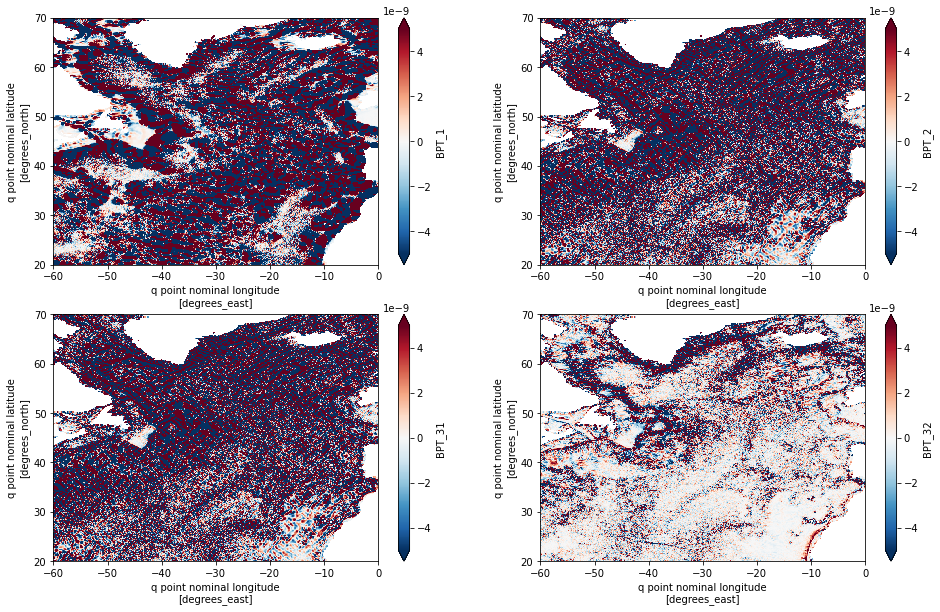

In [17]:
fig = plt.figure(figsize=[16,10])

plt.subplot(2,2,1)
BPT['BPT_1'].plot(vmin=-5e-9, vmax =5e-9, cmap='RdBu_r')
plt.xlim([-60, 0])
plt.ylim([20, 70])

plt.subplot(2,2,2)
BPT['BPT_2'].plot(vmin=-5e-9, vmax =5e-9, cmap='RdBu_r')
plt.xlim([-60, 0])
plt.ylim([20, 70])

plt.subplot(2,2,3)
BPT['BPT_31'].plot(vmin=-5e-9, vmax =5e-9, cmap='RdBu_r')
plt.xlim([-60, 0])
plt.ylim([20, 70])

plt.subplot(2,2,4)
BPT['BPT_32'].plot(vmin=-5e-9, vmax =5e-9, cmap='RdBu_r')
plt.xlim([-60, 0])
plt.ylim([20, 70])

(20.0, 70.0)

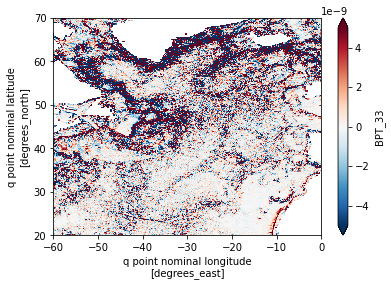

In [20]:
BPT['BPT_33'].plot(vmin=-5e-9, vmax =5e-9, cmap='RdBu_r')
plt.xlim([-60, 0])
plt.ylim([20, 70])

In [21]:
# Rest of the terms in vorticity budget

Curl_dudt = ( - grid.diff(ds['hf_dudt_2d'] * depth_u * ds['dxCu'], 'Y', boundary='fill')
            + grid.diff(ds['hf_dvdt_2d'] * depth_v * ds['dyCv'], 'X', boundary='fill') ) / ds.areacello_bu 
BPT['Curl_dudt'] = (Curl_dudt.load()).assign_coords({'geolat_c': ds['geolat_c'], 'geolon_c': ds['geolon_c']})

Curl_taus = ( - grid.diff((ds['taux'])* ds.dxCu, 'Y', boundary='fill')
                   + grid.diff((ds['tauy'])* ds.dyCv, 'X', boundary='fill') )/ ds.areacello_bu 
Curl_taus = Curl_taus / (rho_0 )
BPT['Curl_taus'] = (Curl_taus.load()).assign_coords({'geolat_c': ds['geolat_c'], 'geolon_c': ds['geolon_c']})

Curl_taub = ( - grid.diff((-ds['taux_bot'])* ds.dxCu, 'Y', boundary='fill')
                   + grid.diff(-ds['tauy_bot'] * ds.dyCv, 'X', boundary='fill') )/ ds.areacello_bu 
Curl_taub = Curl_taub / (rho_0 )
BPT['Curl_taub'] = (Curl_taub.load()).assign_coords({'geolat_c': ds['geolat_c'], 'geolon_c': ds['geolon_c']})

Curl_Hrv = ( - grid.diff((ds['hf_rvxv_2d'] + ds['hf_gKEu_2d']) * depth_u * ds.dxCu, 'Y', boundary='fill')
           + grid.diff((ds['hf_rvxu_2d'] + ds['hf_gKEv_2d']) * depth_v * ds.dyCv, 'X', boundary='fill') )/ ds.areacello_bu 
BPT['Curl_NL'] = (Curl_Hrv.load()).assign_coords({'geolat_c': ds['geolat_c'], 'geolon_c': ds['geolon_c']})

Curl_Hdiff = ( - grid.diff(ds['hf_diffu_2d'] * depth_u * ds.dxCu, 'Y', boundary='fill')
             + grid.diff(ds['hf_diffv_2d']  * depth_v * ds.dyCv, 'X', boundary='fill') )/ ds.areacello_bu 
BPT['Curl_Hdiff'] = (Curl_Hdiff.load()).assign_coords({'geolat_c': ds['geolat_c'], 'geolon_c': ds['geolon_c']})

BPT['vmo_bv'] = vmo_bv
BPT['Qm'] = - Mass_Surf

In [22]:

BPT_g = xr.Dataset() # new xarray dataset for Gaussian-filtered fields with Fixed (coarsening) Factor

fldlist = ['BPT_1','BPT_2','BPT_31', 'BPT_32','Curl_taus','Curl_taub','Curl_NL',
           'Curl_Hdiff','vmo_bv','Qm','Curl_dudt','JEBAR_H','Curl_Cor_H']
dims = ['yq', 'xq']

# Gaussian filter
for fld in fldlist: 
    
    dataBar = BPT[fld].copy() # Initialize the filtering process
    dataBar = dataBar * ds['areacello_bu']

    dataBar = xr.apply_ufunc(apply_gaussian_filter, dataBar, ds['wet_c'], NL_g, sL_g, NB_g, sB_g, 
                             input_core_dims=[dims,dims, [], [], [], []],output_core_dims=[dims], 
                             output_dtypes=[dataBar.dtype], dask='parallelized')

    #dataBar.data = dataBar.data.map_blocks(cp.asnumpy) # send back to host
    dataBar = xr.where(ds['wet_c'],dataBar,np.nan) # mask by nan's if on land
    dataBar = dataBar/ds['areacello_bu'] # divide by cell area    

    BPT_g[fld] = dataBar.copy()

(20.0, 70.0)

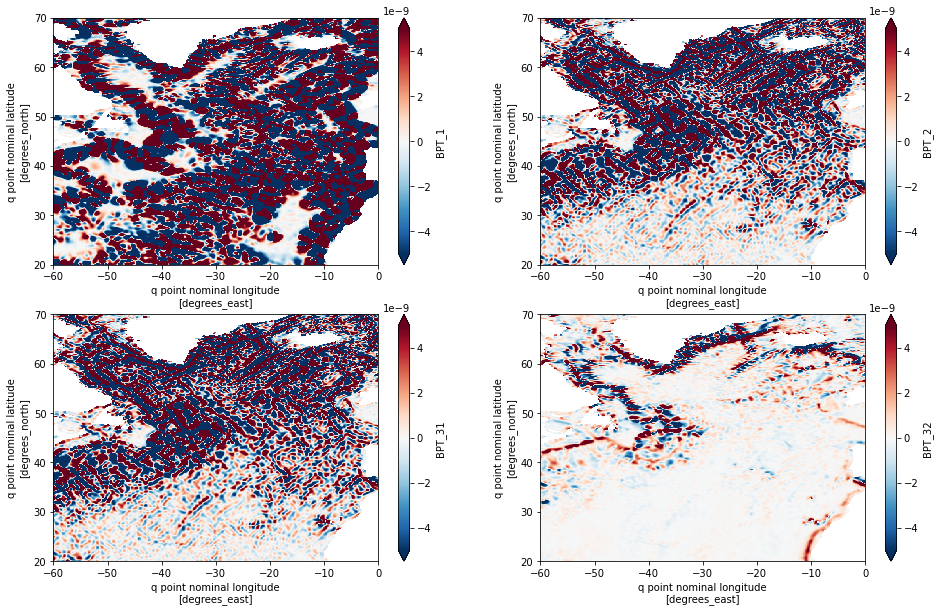

In [23]:
fig = plt.figure(figsize=[16,10])

plt.subplot(2,2,1)
BPT_g['BPT_1'].plot(vmin=-5e-9, vmax =5e-9, cmap='RdBu_r')
plt.xlim([-60, 0])
plt.ylim([20, 70])

plt.subplot(2,2,2)
BPT_g['BPT_2'].plot(vmin=-5e-9, vmax =5e-9, cmap='RdBu_r')
plt.xlim([-60, 0])
plt.ylim([20, 70])

plt.subplot(2,2,3)
BPT_g['BPT_31'].plot(vmin=-5e-9, vmax =5e-9, cmap='RdBu_r')
plt.xlim([-60, 0])
plt.ylim([20, 70])

plt.subplot(2,2,4)
BPT_g['BPT_32'].plot(vmin=-5e-9, vmax =5e-9, cmap='RdBu_r')
plt.xlim([-60, 0])
plt.ylim([20, 70])

### Plots for all terms

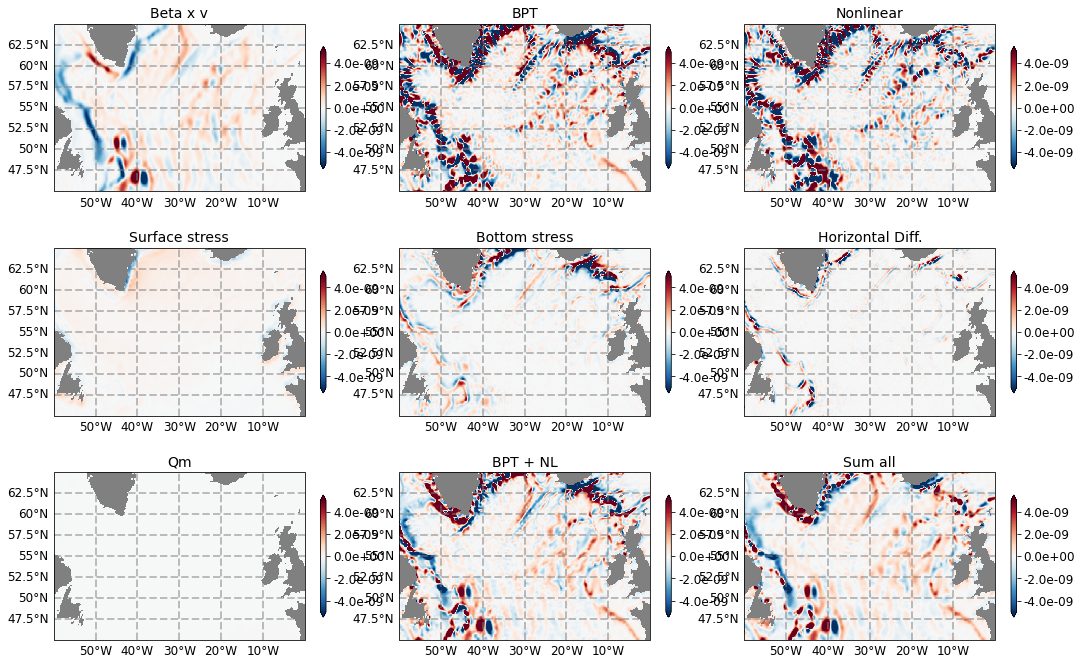

In [26]:
max_r = 5.e-9
lat_lon_ext = [-60, 0, 45., 65.]

grid1 = plt.GridSpec(3, 3, wspace=0.1, hspace=0.1)
fig = plt.figure(figsize=[18,12])

ax = fig.add_subplot(grid1[0, 0], projection=ccrs.PlateCarree(),facecolor='grey')
_ = plot_sec(ax, BPT_g['vmo_bv'], vmin=-max_r, vmax=max_r, vstep=2.e-3*max_r, lat_lon_ext = lat_lon_ext,
                   lon='geolon_c', lat='geolat_c', cmap='RdBu_r', title='Beta x v')

ax = fig.add_subplot(grid1[0, 1], projection=ccrs.PlateCarree(),facecolor='grey')
_ = plot_sec(ax, BPT_g['BPT_32'], vmin=-max_r, vmax=max_r, vstep=2.e-3*max_r, lat_lon_ext = lat_lon_ext,
                   lon='geolon_c', lat='geolat_c', cmap='RdBu_r', title='BPT')

ax = fig.add_subplot(grid1[0, 2], projection=ccrs.PlateCarree(),facecolor='grey')
_ = plot_sec(ax, BPT_g['Curl_NL'], vmin=-max_r, vmax=max_r, vstep=2.e-3*max_r, lat_lon_ext = lat_lon_ext,
                   lon='geolon_c', lat='geolat_c', cmap='RdBu_r', title='Nonlinear')

ax = fig.add_subplot(grid1[1, 0], projection=ccrs.PlateCarree(),facecolor='grey')
_ = plot_sec(ax, BPT_g['Curl_taus'], vmin=-max_r, vmax=max_r, vstep=2.e-3*max_r, lat_lon_ext = lat_lon_ext,
                   lon='geolon_c', lat='geolat_c', cmap='RdBu_r', title='Surface stress')

ax = fig.add_subplot(grid1[1, 1], projection=ccrs.PlateCarree(),facecolor='grey')
_ = plot_sec(ax, BPT_g['Curl_taub'], vmin=-max_r, vmax=max_r, vstep=2.e-3*max_r, lat_lon_ext = lat_lon_ext,
                   lon='geolon_c', lat='geolat_c', cmap='RdBu_r', title='Bottom stress')

ax = fig.add_subplot(grid1[1, 2], projection=ccrs.PlateCarree(),facecolor='grey')
_ = plot_sec(ax, BPT_g['Curl_Hdiff'], vmin=-max_r, vmax=max_r, vstep=2.e-3*max_r, lat_lon_ext = lat_lon_ext,
                   lon='geolon_c', lat='geolat_c', cmap='RdBu_r', title='Horizontal Diff.')

ax = fig.add_subplot(grid1[2, 0], projection=ccrs.PlateCarree(),facecolor='grey')
_ = plot_sec(ax, BPT_g['Qm'], vmin=-max_r, vmax=max_r, vstep=2.e-3*max_r, lat_lon_ext = lat_lon_ext,
                   lon='geolon_c', lat='geolat_c', cmap='RdBu_r', title='Qm')

ax = fig.add_subplot(grid1[2, 1], projection=ccrs.PlateCarree(),facecolor='grey')
_ = plot_sec(ax, BPT_g['BPT_32'] + BPT_g['Curl_NL'], vmin=-max_r, vmax=max_r, vstep=2.e-3*max_r, lat_lon_ext = lat_lon_ext,
                   lon='geolon_c', lat='geolat_c', cmap='RdBu_r', title='BPT + NL')

tmp = BPT_g['BPT_32'] + BPT_g['Curl_NL'] + BPT_g['Qm'] + BPT_g['Curl_Hdiff'] + BPT_g['Curl_taub'] + BPT_g['Curl_taus']
ax = fig.add_subplot(grid1[2, 2], projection=ccrs.PlateCarree(),facecolor='grey')
_ = plot_sec(ax, tmp, vmin=-max_r, vmax=max_r, vstep=2.e-3*max_r, lat_lon_ext = lat_lon_ext,
                   lon='geolon_c', lat='geolat_c', cmap='RdBu_r', title='Sum all')

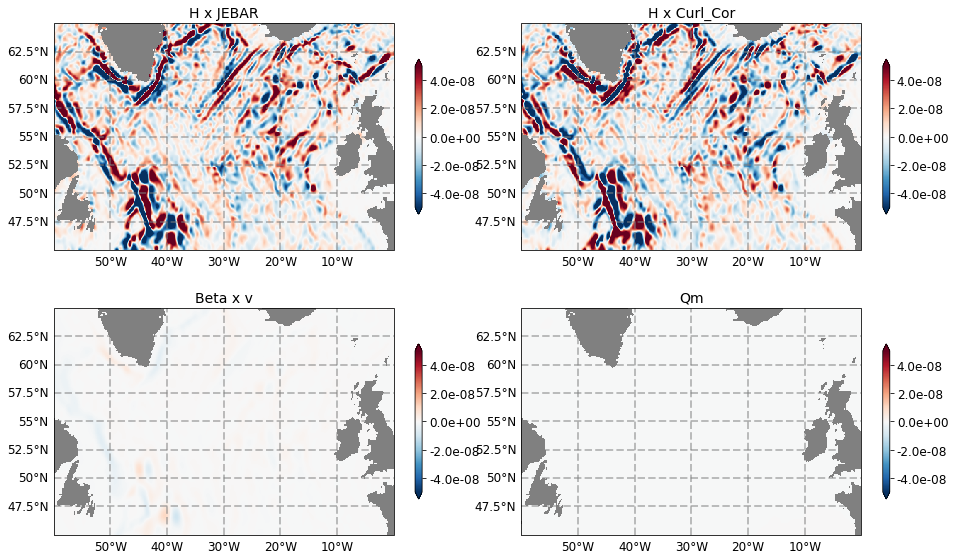

In [26]:
max_r = 5.e-8
lat_lon_ext = [-60, 0, 45., 65.]

grid1 = plt.GridSpec(2, 2, wspace=0.1, hspace=0.1)
fig = plt.figure(figsize=[16,10])

ax = fig.add_subplot(grid1[0, 0], projection=ccrs.PlateCarree(),facecolor='grey')
_ = plot_sec(ax, BPT_g['JEBAR_H'], vmin=-max_r, vmax=max_r, vstep=2.e-3*max_r, lat_lon_ext = lat_lon_ext,
                   lon='geolon_c', lat='geolat_c', cmap='RdBu_r', title='H x JEBAR')

ax = fig.add_subplot(grid1[0, 1], projection=ccrs.PlateCarree(),facecolor='grey')
_ = plot_sec(ax, BPT_g['Curl_Cor_H'], vmin=-max_r, vmax=max_r, vstep=2.e-3*max_r, lat_lon_ext = lat_lon_ext,
                   lon='geolon_c', lat='geolat_c', cmap='RdBu_r', title='H x Curl_Cor')

ax = fig.add_subplot(grid1[1, 0], projection=ccrs.PlateCarree(),facecolor='grey')
_ = plot_sec(ax, BPT_g['vmo_bv'], vmin=-max_r, vmax=max_r, vstep=2.e-3*max_r, lat_lon_ext = lat_lon_ext,
                   lon='geolon_c', lat='geolat_c', cmap='RdBu_r', title='Beta x v')

ax = fig.add_subplot(grid1[1, 1], projection=ccrs.PlateCarree(),facecolor='grey')
_ = plot_sec(ax, BPT_g['Qm'], vmin=-max_r, vmax=max_r, vstep=2.e-3*max_r, lat_lon_ext = lat_lon_ext,
                   lon='geolon_c', lat='geolat_c', cmap='RdBu_r', title='Qm')

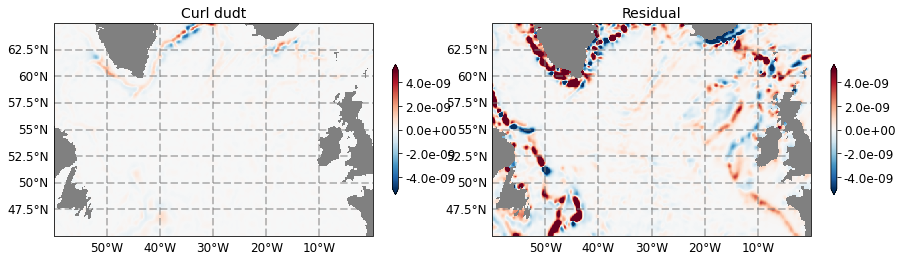

In [30]:
max_r = 5.e-9
lat_lon_ext = [-60, 0, 45., 65.]

grid1 = plt.GridSpec(1, 2, wspace=0.1, hspace=0.1)
fig = plt.figure(figsize=[15,4])

ax = fig.add_subplot(grid1[0, 0], projection=ccrs.PlateCarree(),facecolor='grey')
_ = plot_sec(ax, BPT_g['Curl_dudt'], vmin=-max_r, vmax=max_r, vstep=2.e-3*max_r, lat_lon_ext = lat_lon_ext,
                   lon='geolon_c', lat='geolat_c', cmap='RdBu_r', title='Curl dudt')


tmp = (BPT_g['BPT_32'] + BPT_g['Curl_NL'] + BPT_g['Qm'] + BPT_g['Curl_Hdiff'] + BPT_g['Curl_taub'] + BPT_g['Curl_taus']
      - BPT_g['Curl_dudt'] - BPT_g['vmo_bv'])
ax = fig.add_subplot(grid1[0, 1], projection=ccrs.PlateCarree(),facecolor='grey')
_ = plot_sec(ax, tmp, vmin=-max_r, vmax=max_r, vstep=2.e-3*max_r, lat_lon_ext = lat_lon_ext,
                   lon='geolon_c', lat='geolat_c', cmap='RdBu_r', title='Residual')

ValueError: x must be one of None, 'xq', 'yh'

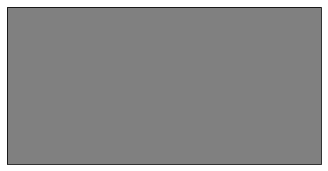

In [28]:
# Momentum Budget

max_r = 5.e-8
lat_lon_ext = [-60, 0, 45., 65.]

grid1 = plt.GridSpec(3, 3, wspace=0.1, hspace=0.1)
fig = plt.figure(figsize=[18,12])

tmp = ds['hf_dudt_2d'].assign_coords({'geolat_u': ds['geolat_u'], 'geolon_u': ds['geolon_u']})
ax = fig.add_subplot(grid1[0, 0], projection=ccrs.PlateCarree(),facecolor='grey')
_ = plot_sec(ax, tmp, vmin=-max_r, vmax=max_r, vstep=2.e-3*max_r, lat_lon_ext = lat_lon_ext,
                   lon='geolon_u', lat='geolat_u', cmap='RdBu_r', title='du/dt')

tmp = (ds['hf_CAu_2d'] - ds['hf_gKEu_2d'] - ds['hf_rvxv_2d']).assign_coords({'geolat_u': ds['geolat_u'], 'geolon_u': ds['geolon_u']})
ax = fig.add_subplot(grid1[0, 1], projection=ccrs.PlateCarree(),facecolor='grey')
_ = plot_sec(ax, tmp, vmin=-1e2*max_r, vmax=1e2*max_r, vstep=2.e-3*max_r, lat_lon_ext = lat_lon_ext,
                   lon='geolon_u', lat='geolat_u', cmap='RdBu_r', title='Cor. Adv. Accel.')

tmp = (ds['hf_PFu_2d']+ds['hf_u_BT_accel_2d']).assign_coords({'geolat_u': ds['geolat_u'], 'geolon_u': ds['geolon_u']})
ax = fig.add_subplot(grid1[0, 2], projection=ccrs.PlateCarree(),facecolor='grey')
_ = plot_sec(ax, tmp, vmin=-1e2*max_r, vmax=1e2*max_r,  vstep=2.e-3*max_r, lat_lon_ext = lat_lon_ext,
                   lon='geolon_u', lat='geolat_u', cmap='RdBu_r', title='Press. Accel.')

tmp = (ds['hf_gKEu_2d'] + ds['hf_rvxv_2d']).assign_coords({'geolat_u': ds['geolat_u'], 'geolon_u': ds['geolon_u']})
ax = fig.add_subplot(grid1[1, 0], projection=ccrs.PlateCarree(),facecolor='grey')
_ = plot_sec(ax, tmp, vmin=-max_r, vmax=max_r, vstep=2.e-3*max_r, lat_lon_ext = lat_lon_ext,
                   lon='geolon_u', lat='geolat_u', cmap='RdBu_r', title='Nonlin. Adv. Accel.')

tmp = ds['hf_du_dt_visc_2d'].assign_coords({'geolat_u': ds['geolat_u'], 'geolon_u': ds['geolon_u']})
ax = fig.add_subplot(grid1[1, 1], projection=ccrs.PlateCarree(),facecolor='grey')
_ = plot_sec(ax, tmp, vmin=-max_r, vmax=max_r, vstep=2.e-3*max_r, lat_lon_ext = lat_lon_ext,
                   lon='geolon_u', lat='geolat_u', cmap='RdBu_r', title='Bound. Stress Accel.')

tmp = ds['hf_diffu_2d'].assign_coords({'geolat_u': ds['geolat_u'], 'geolon_u': ds['geolon_u']})
ax = fig.add_subplot(grid1[1, 2], projection=ccrs.PlateCarree(),facecolor='grey')
_ = plot_sec(ax, tmp, vmin=-max_r, vmax=max_r, vstep=2.e-3*max_r, lat_lon_ext = lat_lon_ext,
                   lon='geolon_u', lat='geolat_u', cmap='RdBu_r', title='Hor. Diff. Accel.')

tmp = (ds['hf_dudt_2d']-ds['hf_CAu_2d']-ds['hf_PFu_2d']-ds['hf_diffu_2d']-ds['hf_du_dt_visc_2d']-
       ds['hf_u_BT_accel_2d']).assign_coords({'geolat_u': ds['geolat_u'], 'geolon_u': ds['geolon_u']})
ax = fig.add_subplot(grid1[2, 0], projection=ccrs.PlateCarree(),facecolor='grey')
_ = plot_sec(ax, tmp, vmin=-max_r, vmax=max_r, vstep=2.e-3*max_r, lat_lon_ext = lat_lon_ext,
                   lon='geolon_u', lat='geolat_u', cmap='RdBu_r', title='Vert. remap. Accel.')

In [30]:
print(ds['hf_dudt_2d'])

<xarray.DataArray 'hf_dudt_2d' (yh: 964, xq: 835)>
[804940 values with dtype=float32]
Coordinates:
  * yh       (yh) float64 0.0 0.125 0.25 0.375 0.5 ... 79.78 79.84 79.89 79.95
  * xq       (xq) float64 -100.0 -99.85 -99.7 -99.55 ... 9.541 9.657 9.773 9.888


### Old Code

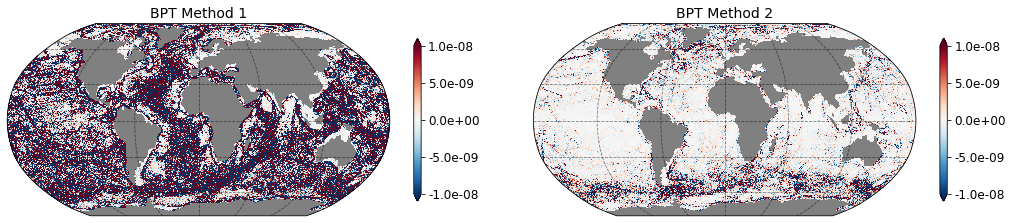

In [27]:
max_r = 1.e-8

grid1 = plt.GridSpec(1, 2, wspace=0.1, hspace=0.1)
fig = plt.figure(figsize=[18,5])

ax = fig.add_subplot(grid1[0, 0], projection=ccrs.Robinson(),facecolor='grey')
_ = plot_map(ax, BPT_1.isel(yq=slice(0,2239)), vmin=-max_r, vmax=max_r, vstep=500.,
                   lon='geolon_c', lat='geolat_c', cmap='RdBu_r', title='BPT Method 1')

ax = fig.add_subplot(grid1[0, 1], projection=ccrs.Robinson(),facecolor='grey')
_ = plot_map(ax, BPT_2.isel(yq=slice(0,2239)), vmin=-max_r, vmax=max_r, vstep=5.,
                   lon='geolon_c', lat='geolat_c', cmap='RdBu_r', title='BPT Method 2')

(20.0, 70.0)

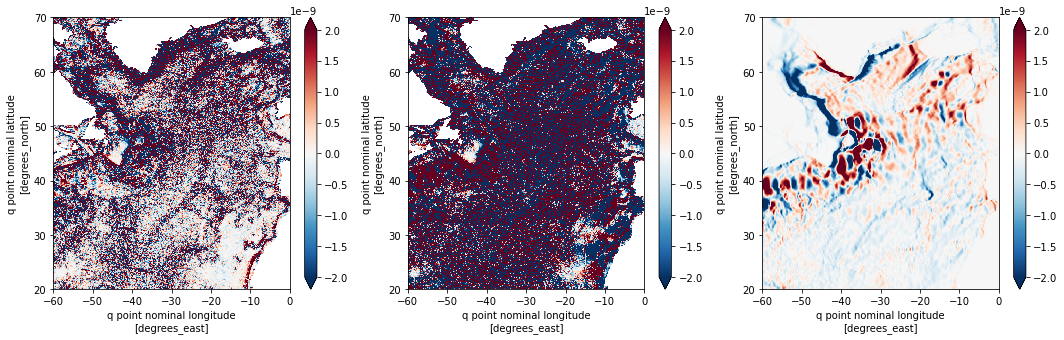

In [49]:
# BPT is very noisy. Will require smoothening the data

fig = plt.figure(figsize=[18,5])

plt.subplot(1,3,1)
BPT_2.plot(vmin=-2e-9, vmax =2e-9, cmap='RdBu_r')
plt.xlim([-60, 0])
plt.ylim([20, 70])

plt.subplot(1,3,2)
BPT_1_eta.plot(vmin=-2e-9, vmax =2e-9, cmap='RdBu_r')
plt.xlim([-60, 0])
plt.ylim([20, 70])

plt.subplot(1,3,3)
(vmo_bv).plot(vmin=-2e-9, vmax =2e-9, cmap='RdBu_r')
plt.xlim([-60, 0])
plt.ylim([20, 70])

In [30]:
Curl_dudt = ( - grid.diff(ds['hf_dudt_2d'] * ds['dxCu'], 'Y', boundary='fill')
            + grid.diff(ds['hf_dvdt_2d'] * ds['dyCv'], 'X', boundary='fill') ) / ds.areacello_bu 
BPT['Curl_dudt'] = Curl_dudt.assign_coords({'geolat_c': ds['geolat_c'], 'geolon_c': ds['geolon_c']})

Curl_tau = ( - grid.diff((ds['taux']-ds['taux_bot'])* ds.dxCu, 'Y', boundary='fill')
                   + grid.diff((ds['tauy']-ds['tauy_bot'])* ds.dyCv, 'X', boundary='fill') )/ ds.areacello_bu 
Curl_tau = Curl_tau / (rho_0 )
BPT['Curl_tau'] = Curl_tau.assign_coords({'geolat_c': ds['geolat_c'], 'geolon_c': ds['geolon_c']})

Curl_Hrv = ( - grid.diff(ds['hf_rvxv_2d'] * depth_u * ds.dxCu, 'Y', boundary='fill')
           + grid.diff(ds['hf_rvxu_2d'] * depth_v * ds.dyCv, 'X', boundary='fill') )/ ds.areacello_bu 
BPT['Curl_Hrv'] = Curl_Hrv.assign_coords({'geolat_c': ds['geolat_c'], 'geolon_c': ds['geolon_c']})

Curl_Hdiff = ( - grid.diff(ds['hf_diffu_2d'] * depth_u * ds.dxCu, 'Y', boundary='fill')
             + grid.diff(ds['hf_diffv_2d']  * depth_v * ds.dyCv, 'X', boundary='fill') )/ ds.areacello_bu 
BPT['Curl_Hdiff'] = Curl_Hdiff.assign_coords({'geolat_c': ds['geolat_c'], 'geolon_c': ds['geolon_c']})

(20.0, 70.0)

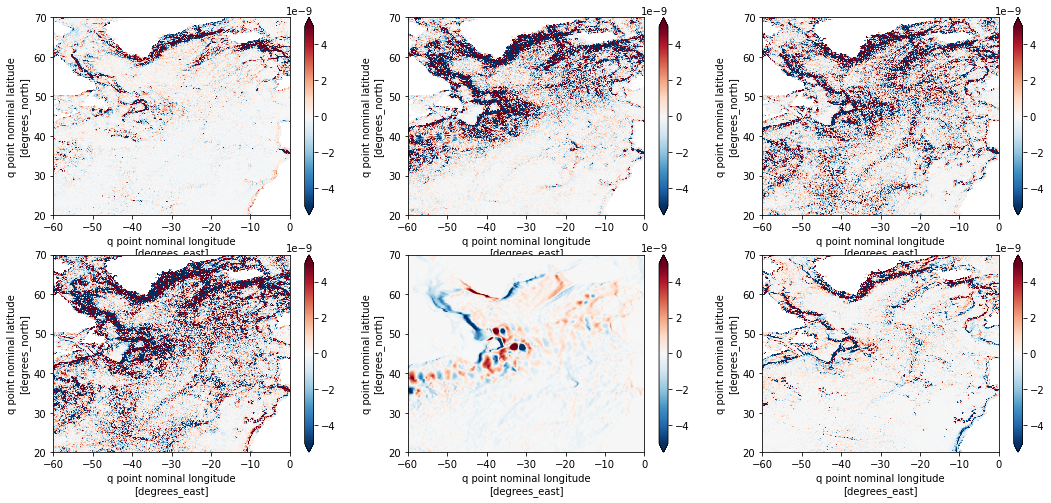

In [33]:
# This is raw picture

fig = plt.figure(figsize=[18,8])
plt.subplot(2,3,1)
(Curl_tau).plot(vmin=-5e-9, vmax =5e-9, cmap='RdBu_r')
plt.xlim([-60, 0])
plt.ylim([20, 70])

plt.subplot(2,3,2)
(Curl_Hrv).plot(vmin=-5e-9, vmax =5e-9, cmap='RdBu_r')
plt.xlim([-60, 0])
plt.ylim([20, 70])

plt.subplot(2,3,3)
(Curl_Hdiff).plot(vmin=-5e-9, vmax =5e-9, cmap='RdBu_r')
plt.xlim([-60, 0])
plt.ylim([20, 70])

plt.subplot(2,3,4)
(BPT_2).plot(vmin=-5e-9, vmax =5e-9, cmap='RdBu_r')
plt.xlim([-60, 0])
plt.ylim([20, 70])

plt.subplot(2,3,5)
(vmo_bv).plot(vmin=-5e-9, vmax =5e-9, cmap='RdBu_r')
plt.xlim([-60, 0])
plt.ylim([20, 70])

tmp = vmo_bv - BPT_2 - Curl_Hrv - Curl_Hdiff - Curl_tau
plt.subplot(2,3,6)
(tmp).plot(vmin=-5e-9, vmax =5e-9, cmap='RdBu_r')
plt.xlim([-60, 0])
plt.ylim([20, 70])

(20.0, 70.0)

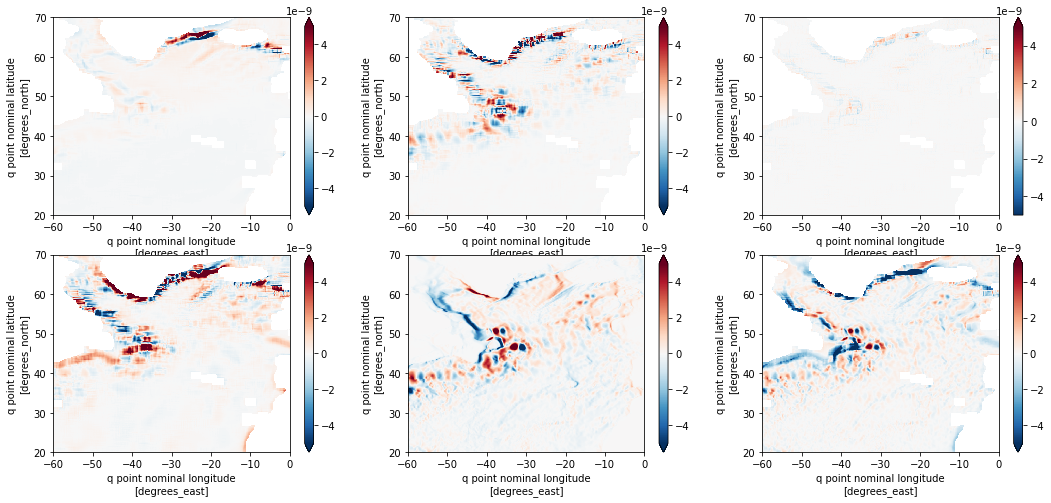

In [51]:
# This is with some smoothening (20 grid points)

fig = plt.figure(figsize=[18,8])
plt.subplot(2,3,1)
(Curl_tau.load().rolling(xq = 20, center=True).mean().rolling(yq=20, center=True).mean()).plot(vmin=-5e-9, vmax =5e-9, cmap='RdBu_r')
plt.xlim([-60, 0])
plt.ylim([20, 70])

plt.subplot(2,3,2)
(Curl_Hrv.load().rolling(xq = 20, center=True).mean().rolling(yq=20, center=True).mean()).plot(vmin=-5e-9, vmax =5e-9, cmap='RdBu_r')
plt.xlim([-60, 0])
plt.ylim([20, 70])

plt.subplot(2,3,3)
(Curl_Hdiff.load().rolling(xq = 20, center=True).mean().rolling(yq=20, center=True).mean()).plot(vmin=-5e-9, vmax =5e-9, cmap='RdBu_r')
plt.xlim([-60, 0])
plt.ylim([20, 70])

plt.subplot(2,3,4)
(BPT_2.load().rolling(xq = 20, center=True).mean().rolling(yq=20, center=True).mean()).plot(vmin=-5e-9, vmax =5e-9, cmap='RdBu_r')
plt.xlim([-60, 0])
plt.ylim([20, 70])

plt.subplot(2,3,5)
(vmo_bv).plot(vmin=-5e-9, vmax =5e-9, cmap='RdBu_r')
plt.xlim([-60, 0])
plt.ylim([20, 70])

tmp = vmo_bv - (BPT_2 + Curl_Hrv + Curl_Hdiff + Curl_tau).load().rolling(xq = 20, center=True).mean().rolling(yq=20, center=True).mean()
plt.subplot(2,3,6)
(tmp).plot(vmin=-5e-9, vmax =5e-9, cmap='RdBu_r')
plt.xlim([-60, 0])
plt.ylim([20, 70])

(20.0, 70.0)

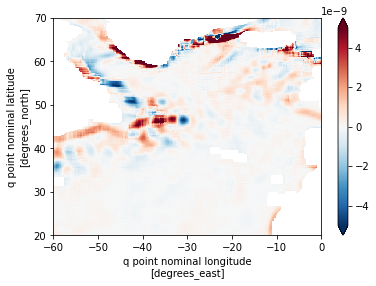

In [40]:
((BPT_2+Curl_Hrv).load().rolling(xq = 20, center=True).mean().rolling(yq=20, center=True).mean()).plot(vmin=-5e-9, vmax =5e-9, cmap='RdBu_r')
plt.xlim([-60, 0])
plt.ylim([20, 70])

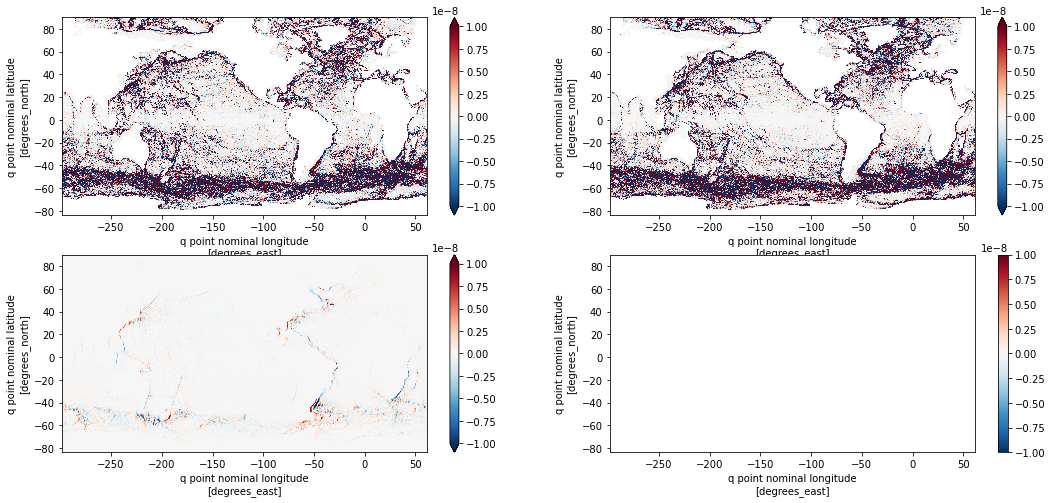

In [18]:
fig = plt.figure(figsize=[18,8])

plt.subplot(2,2,1)
(depth_q*JEBAR).plot(vmin=-1e-8, vmax =1e-8, cmap='RdBu_r')

plt.subplot(2,2,2)
(depth_q * Curl_Cor).plot(vmin=-1e-8, vmax =1e-8, cmap='RdBu_r')

plt.subplot(2,2,3)
(vmo_bv).plot(vmin=-1e-8, vmax =1e-8, cmap='RdBu_r')

plt.subplot(2,2,4)
(Mass_Surf).plot(vmin=-1e-8, vmax =1e-8, cmap='RdBu_r')

In [22]:
(Mass_Surf).values

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)

In [95]:
ds.close()
#client.close()
#cluster.close()

NameError: name 'client' is not defined